# Classical RBM training on the Bars-And-Stripes Dataset for Reconstruction
This is an example on classical Gibbs training of an RBM on the BAS(4,4)
dataset.
Developed by: Jose Pinilla

In [1]:
# Required packages
import qaml
import torch
torch.manual_seed(0) # For deterministic weights

import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms


In [2]:
################################# Hyperparameters ##############################
M,N = SHAPE = (8,8)
DATA_SIZE = N*M
HIDDEN_SIZE = 64
EPOCHS = 200
SAMPLES = None
BATCH_SIZE = 400
TRAIN,TEST = SPLIT = 400,110
# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 0.001
momentum = 0.5


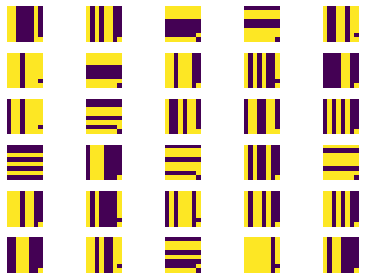

In [3]:
#################################### Input Data ################################
bas_dataset = qaml.datasets.BAS(*SHAPE,embed_label=True,transform=torch.Tensor)
train_dataset,test_dataset = torch.utils.data.random_split(bas_dataset,[*SPLIT])
train_sampler = torch.utils.data.RandomSampler(train_dataset,replacement=False,
                                               num_samples=SAMPLES)
train_loader = torch.utils.data.DataLoader(train_dataset,sampler=train_sampler,
                                           batch_size=BATCH_SIZE)

# PLot all data
fig,axs = plt.subplots(6,5)
for ax,(img,label) in zip(axs.flat,train_dataset):
    ax.matshow(img.view(*SHAPE),vmin=0,vmax=1); ax.axis('off')
plt.tight_layout()


In [4]:
################################# Model Definition #############################
# Specify model with dimensions
rbm = qaml.nn.RBM(DATA_SIZE, HIDDEN_SIZE)

# Initialize biases
weight_init = 0.5
_ = torch.nn.init.constant_(rbm.b,0.5)
_ = torch.nn.init.zeros_(rbm.c)
_ = torch.nn.init.uniform_(rbm.W,-weight_init,weight_init)

# Set up optimizer
optimizer = torch.optim.SGD(rbm.parameters(),lr=learning_rate,
                            weight_decay=weight_decay,momentum=momentum)

# Set up training mechanisms
beta = 1.0
gibbs_sampler = qaml.sampler.GibbsNetworkSampler(rbm,beta=beta)
CD = qaml.autograd.SampleBasedConstrastiveDivergence()


In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
accuracy_log = []
b_log = [rbm.b.detach().clone().numpy()]
c_log = [rbm.c.detach().clone().numpy()]
W_log = [rbm.W.detach().clone().numpy().flatten()]
for t in range(EPOCHS):
    epoch_error = torch.Tensor([0.])
    for img_batch, labels_batch in train_loader:
        input_data = img_batch.flatten(1)

        scale = beta
        # Positive Phase
        v0, prob_h0 = input_data, rbm(input_data,scale=scale)
        # Negative Phase
        vk, prob_hk = gibbs_sampler(v0.detach(), k=5)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply((v0,prob_h0), (vk,prob_hk), *rbm.parameters())

        # Do not accumulate gradients
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        #Accumulate error for this epoch
        epoch_error  += err

    # Error Log
    b_log.append(rbm.b.detach().clone().numpy())
    c_log.append(rbm.c.detach().clone().numpy())
    W_log.append(rbm.W.detach().clone().numpy().flatten())
    err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")
    ############################## CLASSIFICATION ##################################
    count = 0
    for test_data, test_label in test_dataset:
        test_data[-2:,-1] = 0.5
        prob_hk = rbm(test_data.flatten(),scale=scale)
        label_pred = rbm.generate(prob_hk,scale=scale).view(*SHAPE)[-2:,-1]
        if label_pred.argmax() == test_label.argmax():
            count+=1
    accuracy_log.append(count/TEST)
    print(f"Testing accuracy: {count}/{TEST} ({count/TEST:.2f})")


Epoch 0 Reconstruction Error = 17.35360336303711
Testing accuracy: 50/110 (0.45)
Epoch 1 Reconstruction Error = 7.250593662261963
Testing accuracy: 45/110 (0.41)
Epoch 2 Reconstruction Error = 3.18925142288208
Testing accuracy: 43/110 (0.39)
Epoch 3 Reconstruction Error = 3.0424256324768066
Testing accuracy: 46/110 (0.42)
Epoch 4 Reconstruction Error = 2.846031665802002
Testing accuracy: 48/110 (0.44)
Epoch 5 Reconstruction Error = 2.5192251205444336
Testing accuracy: 47/110 (0.43)
Epoch 6 Reconstruction Error = 2.205266237258911
Testing accuracy: 48/110 (0.44)
Epoch 7 Reconstruction Error = 2.092268466949463
Testing accuracy: 46/110 (0.42)
Epoch 8 Reconstruction Error = 1.7800313234329224
Testing accuracy: 47/110 (0.43)
Epoch 9 Reconstruction Error = 1.5398387908935547
Testing accuracy: 47/110 (0.43)
Epoch 10 Reconstruction Error = 1.3223164081573486
Testing accuracy: 46/110 (0.42)
Epoch 11 Reconstruction Error = 1.2965846061706543
Testing accuracy: 47/110 (0.43)
Epoch 12 Reconstructi

Testing accuracy: 84/110 (0.76)
Epoch 104 Reconstruction Error = 1.2131870985031128
Testing accuracy: 85/110 (0.77)
Epoch 105 Reconstruction Error = 1.6553634405136108
Testing accuracy: 83/110 (0.75)
Epoch 106 Reconstruction Error = 0.6781629323959351
Testing accuracy: 85/110 (0.77)
Epoch 107 Reconstruction Error = 1.3313297033309937
Testing accuracy: 84/110 (0.76)
Epoch 108 Reconstruction Error = 0.8651528358459473
Testing accuracy: 85/110 (0.77)
Epoch 109 Reconstruction Error = 0.8518768548965454
Testing accuracy: 84/110 (0.76)
Epoch 110 Reconstruction Error = 0.9869533181190491
Testing accuracy: 85/110 (0.77)
Epoch 111 Reconstruction Error = 1.0565015077590942
Testing accuracy: 87/110 (0.79)
Epoch 112 Reconstruction Error = 1.0904393196105957
Testing accuracy: 88/110 (0.80)
Epoch 113 Reconstruction Error = 0.7556275725364685
Testing accuracy: 90/110 (0.82)
Epoch 114 Reconstruction Error = 0.699201226234436
Testing accuracy: 90/110 (0.82)
Epoch 115 Reconstruction Error = 0.9856592416

Dataset Reconstruction: 0.35


<BarContainer object of 16 artists>

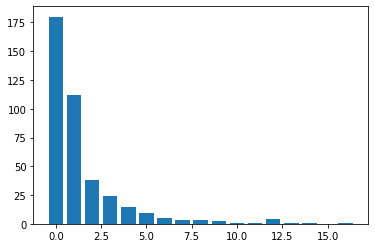

In [6]:
############################## RECONSTRUCTION ##################################
k = 10
hist = {}
count = 0
mask = torch_transforms.functional.erase(torch.ones(1,M,N),2,2,4,4,0).flatten()
for img, label in train_dataset:
    clamped = mask*(img.flatten().detach().clone())
    prob_hk = rbm.forward(clamped + (1-mask)*0.5,scale=scale)
    prob_vk = rbm.generate(prob_hk,scale=scale).detach()
    for _ in range(k):
        masked = clamped + (1-mask)*prob_vk.data
        prob_hk.data = rbm.forward(masked,scale=scale).data
        prob_vk.data = rbm.generate(prob_hk,scale=scale).data
    recon = (clamped + (1-mask)*prob_vk).bernoulli().view(img.shape)
    if recon.equal(img):
        count+=1
    num = torch.count_nonzero(recon.to(bool).bitwise_xor(img.to(bool))).item()
    hist[num]=hist.get(num,0)+1
print(f"Dataset Reconstruction: {count/(TEST+TRAIN):.02}")
plt.bar(hist.keys(),hist.values())


Text(0.5, 0, 'Epoch')

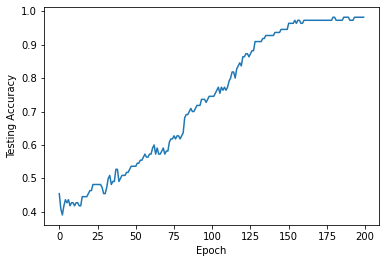

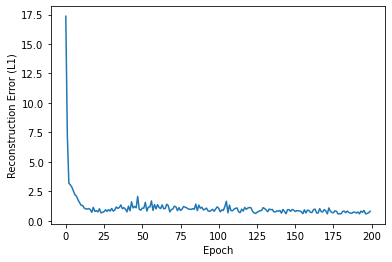

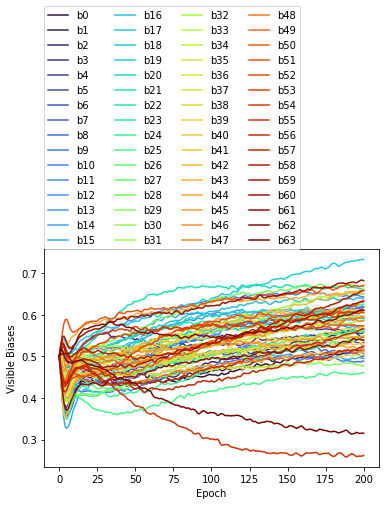

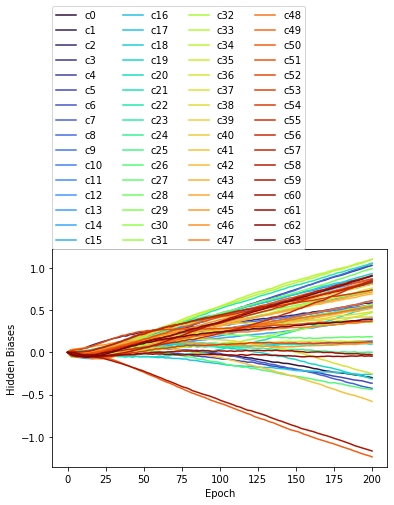

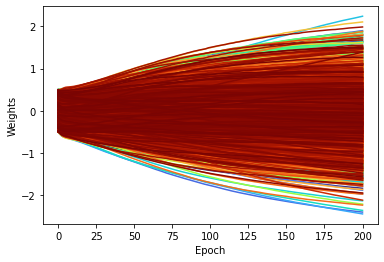

In [7]:
############################ MODEL VISUALIZATION ###############################
# Testing accuracy graph
fig, ax = plt.subplots()
plt.plot(accuracy_log)
plt.ylabel("Testing Accuracy")
plt.xlabel("Epoch")
plt.savefig("classical_accuracy.pdf")

# L1 error graph
fig, ax = plt.subplots()
plt.plot(err_log)
plt.ylabel("Reconstruction Error (L1)")
plt.xlabel("Epoch")
plt.savefig("classical_err_log.pdf")

# Visible bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',DATA_SIZE).colors))
lc_v = ax.plot(b_log)
plt.legend(lc_v,[f'b{i}' for i in range(DATA_SIZE)],ncol=4,loc=(0,1))
plt.ylabel("Visible Biases")
plt.xlabel("Epoch")
plt.savefig("classival_b_log.pdf")

# Hidden bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',HIDDEN_SIZE).colors))
lc_h = plt.plot(c_log)
plt.legend(lc_h,[f'c{i}' for i in range(HIDDEN_SIZE)],ncol=4,loc=(0,1))
plt.ylabel("Hidden Biases")
plt.xlabel("Epoch")
plt.savefig("classical_c_log.pdf")

# Weights graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',rbm.V*rbm.H).colors))
lc_w = plt.plot(W_log)
plt.ylabel("Weights")
plt.xlabel("Epoch")


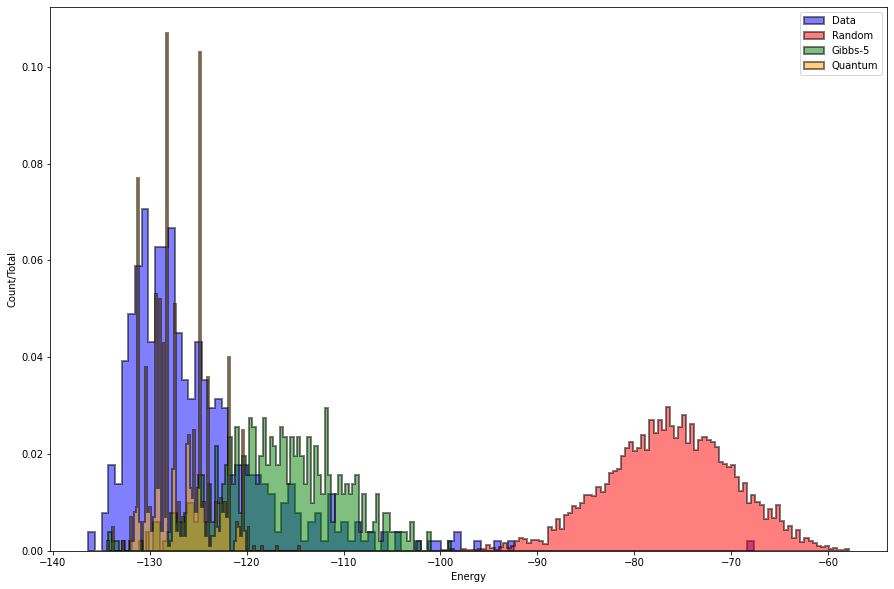

In [8]:
################################## ENERGY ######################################
data_energies = []
for img,label in bas_dataset:
    data = img.flatten()
    data_energies.append(rbm.free_energy(data).item())

rand_energies = []
rand_data = torch.rand(len(bas_dataset)*10,rbm.V)
for img in rand_data:
    rand_energies.append(rbm.free_energy(img.bernoulli()).item())

gibbs_energies = []
for img,label in bas_dataset:
    data = img.flatten()
    prob_v,prob_h = gibbs_sampler(data,k=5)
    gibbs_energies.append(rbm.free_energy(prob_v.bernoulli()).item())

qa_energies = []
solver_name = "Advantage_system4.1"
qa_sampler = qaml.sampler.QASampler(rbm,solver=solver_name)
qa_sampleset = qa_sampler(num_reads=1000,auto_scale=True)
for s_v,s_h in zip(*qa_sampleset):
    qa_energies.append(rbm.free_energy(s_v.detach()).item())

plot_data = [(data_energies,  'Data',    'blue'),
             (rand_energies,  'Random',  'red'),
             (gibbs_energies, 'Gibbs-5', 'green'),
             (qa_energies,    'Quantum', 'orange')]

hist_kwargs = {'ec':'k','lw':2.0,'alpha':0.5,'histtype':'stepfilled','bins':100}
weights = lambda data: [1./len(data) for _ in data]

fig, ax = plt.subplots(figsize=(15,10))
for data,name,color in plot_data:
    ax.hist(data,weights=weights(data),label=name,color=color,**hist_kwargs)

plt.xlabel("Energy")
plt.ylabel("Count/Total")
plt.legend(loc='upper right')
plt.savefig("classical_energies.pdf")


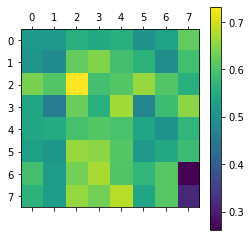

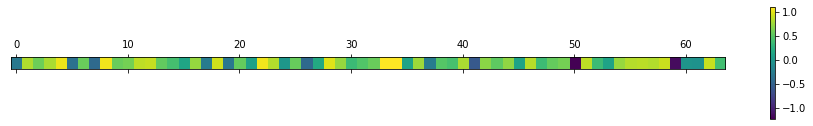

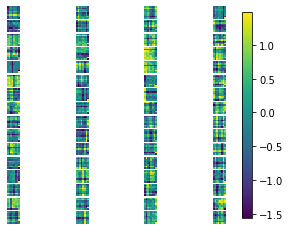

In [9]:
################################## VISUALIZE ###################################
plt.matshow(rbm.b.detach().view(*SHAPE))
plt.colorbar()
plt.savefig("classical_b.pdf")
plt.matshow(rbm.c.detach().view(1,HIDDEN_SIZE))
plt.yticks([])
plt.colorbar()
plt.savefig("classical_c.pdf")

fig,axs = plt.subplots(HIDDEN_SIZE//4,4)
for i,ax in enumerate(axs.flat):
    weight_matrix = rbm.W[i].detach().view(*SHAPE)
    ms = ax.matshow(weight_matrix)
    ax.axis('off')
fig.subplots_adjust(wspace=0.1, hspace=0.1)
cbar = fig.colorbar(ms, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig("classical_weights.pdf")